In [ ]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
os.chdir("/nfs/students/winter-term-2020/project-4/schwienb/project-4")
from src.data.mnist import MNISTDataModule
from src.data.fashionmnist import FashionMNISTDataModule
from src.models.vae.basic_vae_variance import BasicVAEVariance
from src.experiments.experiment import Experiment
import torch.nn.functional as F
from pytorch_lightning.callbacks import LearningRateMonitor

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)

In [3]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.000,
   patience=3,
   verbose=True,
)
lr_monitor = LearningRateMonitor(logging_interval='step')
model_params = {
  'neg_pdf_loss': True
}
dataset_params = {
}
model = BasicVAEVariance
dataset = FashionMNISTDataModule


EarlyStopping mode set to min for monitoring val_loss.


In [4]:
exp = Experiment('VAEVariance_FashionMNIST_PDF_1', 
                 model=model, dataset=dataset, model_params=model_params, dataset_params=dataset_params, callbacks=[early_stop_callback, lr_monitor])
exp.setup_new()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
lr_finder = exp.trainer.tuner.lr_find(exp.model, exp.dataset)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
exp.model.lr = new_lr

In [5]:
exp.train()

Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | fc1          | Linear     | 314 K 
1 | fc_mu_z      | Linear     | 32 K  
2 | fc_log_var_z | Sequential | 32 K  
3 | fc2          | Linear     | 32 K  
4 | fc_mu_x      | Linear     | 314 K 
5 | fc_log_var_x | Sequential | 314 K 
6 | relu         | ReLU       | 0     


/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You are using LearningRateMonitor callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


In [8]:
exp.save()

In [6]:
from src.utils.vae import generate_images

In [7]:
generate_images(exp.model, exp.dataset.test_dataloader())

Traceback (most recent call last):
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

<Figure size 720x1080 with 0 Axes>

In [14]:
mnist = MNISTDataModule()
fashion = FashionMNISTDataModule()

mnist.prepare_data()
mnist.setup()

fashion.prepare_data()
fashion.setup()
mnist_test = mnist.test_dataloader()


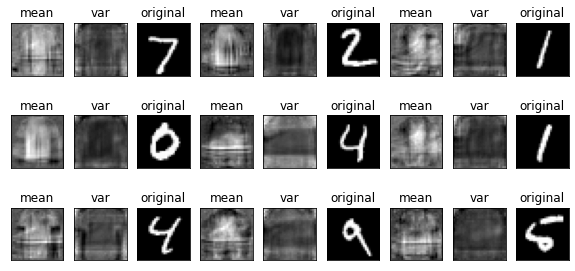

In [15]:
generate_images(exp.model, mnist_test)